# Introduction

In [12]:
import pandas as pd
import numpy as np
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import re
import csv

In [13]:
#Importing data
interactions = pd.read_csv('kaggle_data/interactions_train.csv')
items = pd.read_csv('kaggle_data/items.csv')

display(interactions.head())
display(items.head())

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


# Preliminary data analysis

In [3]:
#Count the number of elements in each column
count_elements = items.count()
count_elements

Title         15291
Author        12638
ISBN Valid    14568
Publisher     15266
Subjects      13068
i             15291
dtype: int64

In [4]:
# How many books did people read?
books_per_user = interactions.groupby('u')['i'].count()

summary_stats = books_per_user.describe()
print(summary_stats)

count    7838.000000
mean       11.105767
std        16.441875
min         3.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       385.000000
Name: i, dtype: float64


In [5]:
#Number of unique users
unique_users = interactions['u'].nunique()
print(f"Number of unique users: {unique_users}")

Number of unique users: 7838


In [6]:
#Missing values for items
missing_values = items.isnull().sum()
missing_values

Title            0
Author        2653
ISBN Valid     723
Publisher       25
Subjects      2223
i                0
dtype: int64

In [7]:
# Convert the timestamp column 't' to datetime format
interactions['date'] = pd.to_datetime(interactions['t'], unit='s')

In [8]:
# Create a copy of the interactions
user_embeddings_df = interactions.copy()

# Sorting the dataframe by user ('u') and timestamp ('t')
user_embeddings_df = user_embeddings_df.sort_values(by=["u", "t"], ascending=[True, False]).reset_index(drop=True)

# For each user calculate the cumulative count of unique books ('i') they interacted with
user_embeddings_df['last_unique_books'] = user_embeddings_df\
    .groupby('u')['i']\
    .apply(lambda x: (~pd.Series(x).duplicated()).cumsum()).reset_index(drop=True)

user_embeddings_df

,u,i,t,date,last_unique_books
0,0,24,1.713272e+09,2024-04-16 12:58:06,1
1,0,23,1.710932e+09,2024-03-20 10:59:22,2
2,0,22,1.710846e+09,2024-03-19 10:57:30,3
3,0,21,1.710779e+09,2024-03-18 16:28:57,4
4,0,20,1.698667e+09,2023-10-30 12:00:45,5
...,...,...,...,...,...
87042,7836,3471,1.728644e+09,2024-10-11 10:54:01,1
87043,7836,14550,1.728644e+09,2024-10-11 10:49:02,2
87044,7837,2209,1.728735e+09,2024-10-12 12:07:35,1
87045,7837,88,1.728735e+09,2024-10-12 12:06:35,2


In [10]:
# Get users who have read exactly 1 unique book
users_with_1_unique_book = user_embeddings_df.groupby('u')['i'].nunique()
users_with_1_unique_book = users_with_1_unique_book[users_with_1_unique_book == 1].index
u_1 = user_embeddings_df[user_embeddings_df['u'].isin(users_with_1_unique_book)].drop_duplicates(subset=['u', 'i'])
u_1

,u,i,t,date,last_unique_books
821,36,669,1.724164e+09,2024-08-20 14:31:19,1
3035,178,2406,1.694169e+09,2023-09-08 10:35:17,1
3621,218,611,1.691075e+09,2023-08-03 15:02:10,1
3959,246,3094,1.707831e+09,2024-02-13 13:33:04,1
3996,250,3118,1.686326e+09,2023-06-09 15:45:58,1
...,...,...,...,...,...
86819,7799,14108,1.725898e+09,2024-09-09 16:04:37,1
86902,7816,14826,1.727356e+09,2024-09-26 13:10:38,1
86911,7818,14555,1.726739e+09,2024-09-19 09:44:51,1
86956,7823,53,1.726938e+09,2024-09-21 17:08:18,1


In [11]:
# Calculate the mean book ID for each user and assign it to a new column
user_embeddings_df['mean_book_id'] = user_embeddings_df.groupby('u')['i'].transform('mean')

# Calculate the standard deviation of book IDs for each user and assign it to a new column
user_embeddings_df['std_book_id'] = user_embeddings_df.groupby('u')['i'].transform('std')

# Calculate the coefficient of variation for book IDs for each user
user_embeddings_df['cv_coeff'] = user_embeddings_df['std_book_id'] / user_embeddings_df['mean_book_id']

# Find the maximum book ID for each user and assign it to a new column
user_embeddings_df['max_book'] = user_embeddings_df.groupby('u')['i'].transform('max')

# Calculate the difference between the maximum book ID and the current book ID for each user
user_embeddings_df['delta_last_max_book'] = user_embeddings_df['max_book'] - user_embeddings_df['i']

# Filter rows where the user has interacted with exactly 1 unique book
tt = user_embeddings_df[user_embeddings_df['last_unique_books'] == 1][
    ['u', 'i', 'max_book', 'mean_book_id', 'std_book_id', 'delta_last_max_book', 'cv_coeff']
].drop_duplicates()

tt

,u,i,max_book,mean_book_id,std_book_id,delta_last_max_book,cv_coeff
0,0,24,24,11.653846,7.423974,0,0.637041
26,1,39,39,34.875000,3.052322,0,0.087522
42,2,92,94,69.915789,15.693652,2,0.224465
137,3,172,172,140.416667,20.020236,0,0.142577
209,4,195,207,198.777778,4.988877,12,0.025098
...,...,...,...,...,...,...,...
87027,7833,7760,7760,5352.333333,3797.202435,0,0.709448
87030,7834,1367,15276,7551.625000,5029.493725,13909,0.666015
87038,7835,6791,6791,4888.666667,1868.946316,0,0.382302
87041,7836,3471,14550,7164.000000,6396.463632,11079,0.892862


In [12]:
# Check one of the users
user_embeddings_df[user_embeddings_df['u'] == 437]

,u,i,t,date,last_unique_books,mean_book_id,std_book_id,cv_coeff,max_book,delta_last_max_book
7069,437,393,1.693307e+09,2023-08-29 11:02:33,1,393.0,0.0,0.0,393,0
7070,437,393,1.680203e+09,2023-03-30 19:01:36,1,393.0,0.0,0.0,393,0
7071,437,393,1.680203e+09,2023-03-30 19:01:33,1,393.0,0.0,0.0,393,0


In [13]:
# Display the first 10 rows where the coefficient of variation is less than 0.1 (indicating low variability)
tt[tt['cv_coeff'] < 0.1].head(10)

,u,i,max_book,mean_book_id,std_book_id,delta_last_max_book,cv_coeff
26,1,39,39,34.875000,3.052322,0,0.087522
209,4,195,207,198.777778,4.988877,12,0.025098
227,5,224,224,218.000000,3.894440,0,0.017864
240,6,231,232,230.125000,1.125992,1,0.004893
248,7,250,250,243.000000,4.472136,0,0.018404
263,8,258,258,257.000000,1.000000,0,0.003891
266,9,262,264,262.333333,1.197219,2,0.004564
287,10,274,274,271.000000,2.160247,0,0.007971
294,11,279,280,278.600000,1.140175,1,0.004093
316,13,321,336,313.988372,10.090758,15,0.032137


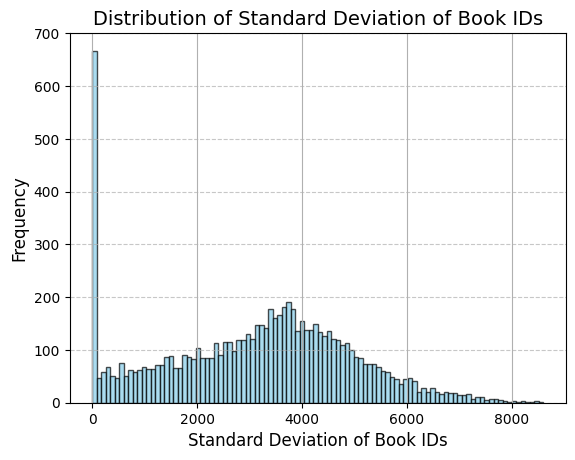

In [16]:
# Plot the histogram of the standard deviation of book IDs per user
tt['std_book_id'].hist(bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Standard Deviation of Book IDs', fontsize=14)
plt.xlabel('Standard Deviation of Book IDs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

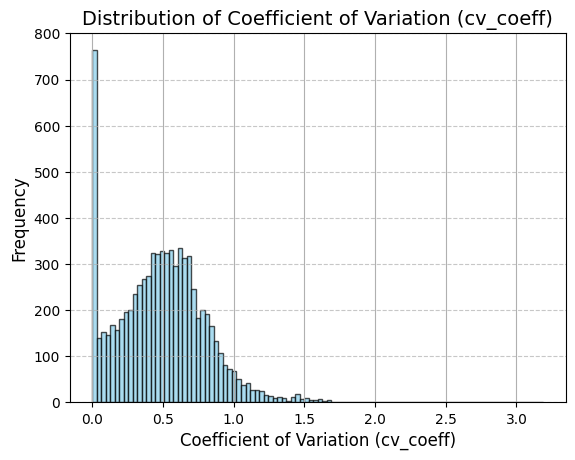

In [18]:
# Plot the histogram of the coefficient of variation (cv_coeff) for users
tt['cv_coeff'].hist(
    bins=100,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
plt.title('Distribution of Coefficient of Variation (cv_coeff)', fontsize=14)
plt.xlabel('Coefficient of Variation (cv_coeff)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
# Display summary statistics for the coefficient of variation
tt['cv_coeff'].describe()

count    7838.000000
mean        0.492312
std         0.318545
min         0.000000
25%         0.265153
50%         0.492184
75%         0.685797
max         3.188640
Name: cv_coeff, dtype: float64

In [20]:
# Filter rows where the difference between the maximum book ID and the current book ID is greater than 1000
tt[tt['delta_last_max_book'] > 1000]

,u,i,max_book,mean_book_id,std_book_id,delta_last_max_book,cv_coeff
1392,53,23,1168,937.800000,511.389969,1145,0.545308
1506,63,44,1256,1080.714286,457.151220,1212,0.423008
1926,99,235,1617,1499.500000,351.180986,1382,0.234199
2100,112,476,1734,1230.600000,687.940259,1258,0.559028
2402,140,902,1946,1684.500000,521.666880,1044,0.309686
...,...,...,...,...,...,...,...
86997,7827,13587,15062,12517.571429,2909.386296,1475,0.232424
87011,7830,1081,13755,5358.333333,5537.805727,12674,1.033494
87017,7831,3405,13310,8946.000000,5056.308238,9905,0.565203
87030,7834,1367,15276,7551.625000,5029.493725,13909,0.666015


count     7838.000000
mean      3617.587905
std       4092.810057
min          0.000000
25%          0.000000
50%       2028.500000
75%       6596.750000
max      15227.000000
Name: delta_last_max_book, dtype: float64

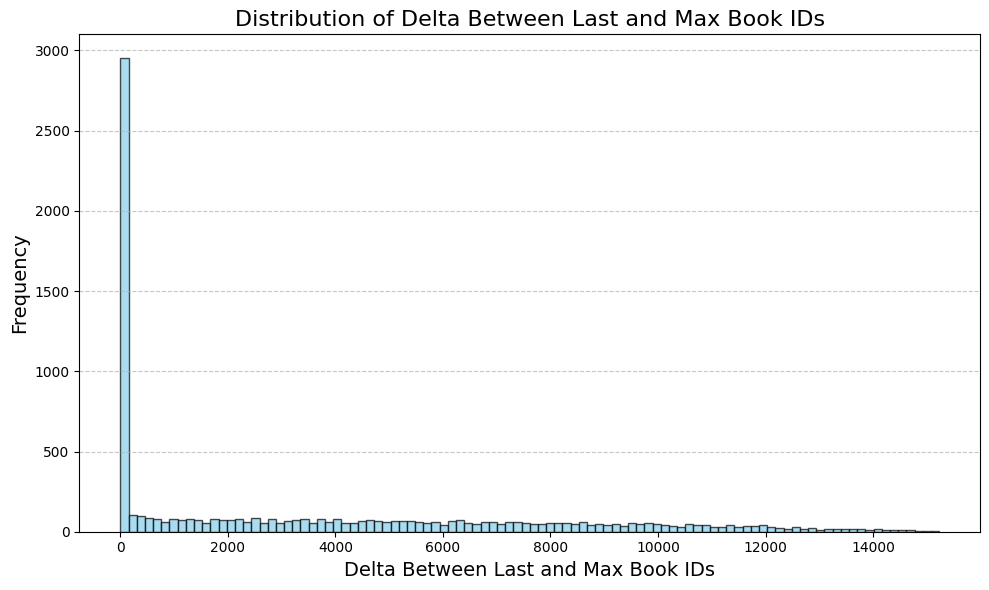

In [ ]:
# Display summary statistics for the 'delta_last_max_book' column
display(tt['delta_last_max_book'].describe())

# Plot a histogram for the 'delta_last_max_book' column
plt.figure(figsize=(10, 6))
plt.hist(tt['delta_last_max_book'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Delta Between Last and Max Book IDs', fontsize=16)
plt.xlabel('Delta Between Last and Max Book IDs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Group interactions by user ('u') and calculate aggregated statistics
analyz = interactions.groupby('u').agg(
    total_books_read = ('i', 'count'),
    unique_books_read = ('i', pd.Series.nunique),
    t_min = ('date', 'min'),
    t_max = ('date', 'max'),
).reset_index()

# Calculate the difference in days between the earliest and latest interaction dates
analyz['days_diff'] = (analyz['t_max'] - analyz['t_min']).dt.days

# Sort the results by the total number of books read in descending order and display the top 20 users
analyz.sort_values(by=["total_books_read"], ascending=False).head(20)

,u,total_books_read,unique_books_read,t_min,t_max,days_diff
6869,6869,385,43,2023-01-10 18:33:29,2023-08-26 16:35:18,227
4473,4473,254,165,2023-01-09 16:23:49,2024-02-14 13:29:27,400
1884,1884,200,30,2023-01-31 11:05:52,2024-06-27 17:19:46,513
732,732,199,26,2023-07-11 12:27:46,2024-04-20 11:51:45,283
1744,1744,175,167,2023-01-03 18:01:37,2024-02-28 15:08:40,420
1106,1106,165,95,2023-01-09 11:04:53,2024-05-24 08:24:41,500
262,262,163,133,2023-01-03 14:32:09,2024-05-07 17:36:06,490
2648,2648,162,133,2023-01-03 14:55:09,2024-03-15 11:16:51,436
7507,7507,157,11,2023-11-27 17:02:40,2024-07-29 15:19:01,244
3274,3274,152,102,2023-01-05 12:12:51,2024-05-21 10:22:15,501


# Collaborative Filtering (first attempts)
Recommendations based on user-item interactions. 


### Train Test Split

In [14]:
interactions = interactions.sort_values(["u", "t"])

interactions["pct_rank"] = interactions.groupby("u")["t"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)

train_data = interactions[interactions["pct_rank"] < 0.9]
test_data = interactions[interactions["pct_rank"] >= 0.9]


print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 73892
Testing set size: 13155


### Collaborative Filtering (simple approach)
Using the initial raw data

In [15]:
# Create a user-item interaction matrix with binary values (1 if read, 0 otherwise)
binary_interaction_matrix = train_data.pivot_table(index='u', columns='i', values='t', aggfunc='count')
binary_interaction_matrix = binary_interaction_matrix.notnull().astype(int)

binary_interaction_matrix

i,0,1,2,3,4,5,6,7,8,9,...,15279,15280,15282,15283,15284,15285,15287,15288,15289,15290
u,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Compute Cosine Similarity Between Users
user_similarity = cosine_similarity(binary_interaction_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=binary_interaction_matrix.index, columns=binary_interaction_matrix.index)
user_similarity_df

u,0,1,2,3,4,5,6,7,8,9,...,7828,7829,7830,7831,7832,7833,7834,7835,7836,7837
u,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101015
3,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
7834,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
7835,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000


In [17]:
k = 10

# 1. user-item scores for every user in one shot
scores = user_similarity_df.values @ binary_interaction_matrix.values        # (U, I)

# 2. indices of each user’s k best-scoring items (unsorted)
top_idx_unsorted = np.argpartition(-scores, k-1, axis=1)[:, :k]              # (U, k)

# 3. sort those k items per user so they’re really rank-ordered
rows   = np.arange(scores.shape[0])[:, None]                                  # (U, 1)
order  = np.argsort(-scores[rows, top_idx_unsorted], axis=1)
top_idx = top_idx_unsorted[rows, order]                                       # (U, k) sorted

# 4. look up the *labels* with NumPy → 2-D array → DataFrame
item_labels = binary_interaction_matrix.columns.to_numpy()                    # (I,)
top_labels  = item_labels[top_idx]                                            # (U, k)

recommendations = pd.DataFrame(
    top_labels,                              # the items
    index=binary_interaction_matrix.index,   # the users
    columns=range(k)                         # rank 0…9
)

# quick peek
print(recommendations.head())

     0    1    2    3    4    5    6    7    8    9
u                                                  
0   13    4   12   15    8   11   14   10    5   17
1   38   34   31   30   37   29   32   33   36   35
2   46   58   53   49   56   64   91   82   71   45
3  149  163  128  143  133  138   40  155  142  156
4  202  203  198  191  193  201  195  197  205  196


In [18]:
# Convert each row of recommendations to a space-separated string
recommendations_str = recommendations.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Export to CSV with a single-column header
recommendations_str.to_csv('recommendations.csv', index=True, header=['recommendation'])

### Collaborative Filtering (better predictions)

In [19]:
# Apply TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(binary_interaction_matrix.values)
item_factors = svd.components_

# Reconstruct approximate interaction scores
approx_scores = user_factors @ item_factors

# Convert reconstructed scores into a DataFrame (same indexes and columns as original)
approx_scores_df = pd.DataFrame(approx_scores, index=binary_interaction_matrix.index, columns=binary_interaction_matrix.columns)

# Get top 10 items for each user
k = 10
recommendations_svd = approx_scores_df.apply(lambda row: row.nlargest(k).index.tolist(), axis=1)
recommendations_svd.head()

u
0    [611, 46, 4, 8999, 794, 3407, 3811, 685, 13, 2...
1    [611, 789, 4220, 5140, 2959, 769, 796, 176, 33...
2    [46, 323, 56, 2130, 5748, 3055, 66, 8999, 70, 64]
3    [163, 149, 618, 611, 128, 466, 119, 4, 2614, 143]
4    [424, 323, 201, 2225, 428, 423, 976, 422, 324,...
dtype: object

# Enriching the initial data

In [ ]:
# create a new DataFrame with only the "ISBN Valid" and "i" columns
new_df = items[['ISBN Valid', 'i']].copy()

# extract the first ISBN (split by ";" and take the first part)
new_df['ISBN Valid'] = new_df['ISBN Valid'].str.split(';').str[0].str.strip()
new_df = new_df.dropna()
new_df

In [ ]:
headers = {
    "accept": "application/json",
    "Authorization": "61340_07e0d88d12a86c44350c47d5634b181b",
    "Content-Type": "application/json",
}

# Split your ISBN column into batches of 100
batches = [
    new_df["ISBN Valid"].iloc[i : i + 100].tolist() 
    for i in range(0, len(new_df), 100)
]

# Hit the API batch-by-batch, but *accumulate* the results
all_books = []                       # <- master list

for batch in batches:
    payload = "isbns=" + ",".join(batch)
    response = requests.post(
        "https://api2.isbndb.com/books", headers=headers, data=payload
    )
    response.raise_for_status()      # throws if the request failed

    batch_json = response.json()   
    print(response.json())
     # dict with a "data" (or "books") key
    books_this_batch = batch_json.get("data", [])   # falls back to [] if key missing
    all_books.extend(books_this_batch)              # add to master list
    
    # optional:  respect a polite rate limit
    time.sleep(0.2)

# Turn the *entire* list into a DataFrame
books_df = pd.DataFrame(all_books)

# df now holds one row per book, across every batch
print(books_df.head())

In [ ]:
items_long = (
    items
      # make every ISBN its own list element …
      .assign(ISBN_list = items["ISBN Valid"].str.split(r"\s*;\s*"))
      # … then one row per ISBN
      .explode("ISBN_list")
      # keep only the digits (and the lone “X” some ISBN‑10s end with)
      .assign(ISBN_clean = lambda d:
              d["ISBN_list"].str.replace(r"[^0-9Xx]", "", regex=True).str.strip())
      .dropna(subset=["ISBN_clean"])      # drop rows where ISBN was missing
      .drop(columns=["ISBN_list"])        # housekeeping
)

In [ ]:
id_cols   = [c for c in books_df.columns if c not in ["isbn13", "isbn10", "isbn"]]
books_norm = (
    books_df
      .melt(id_vars=id_cols,               # keep all the descriptive columns
            value_vars=["isbn13","isbn10","isbn"],
            var_name="isbn_type",          # tells us whether it was 13/10/etc.
            value_name="ISBN_clean")       # the actual digits
      .dropna(subset=["ISBN_clean"])       # some entries may miss a variant
      .astype({"ISBN_clean": "string"})    # make merge safe
)

In [ ]:
items_long["ISBN_clean"] = items_long["ISBN_clean"].astype("string")

merged = (
    items_long
      .merge(books_norm,
             on="ISBN_clean",      # <- single clean key
             how="left")           # keep every item even if the API had no hit
)

merged = merged.drop_duplicates(subset=["ISBN_clean", "i"])

In [ ]:
#keep only one row per i with the most data
merged = (
    merged
      .groupby("i", as_index=False)
      .agg(lambda x: x.iloc[0] if x.notna().any() else None)
)
# Drop the columns that are not needed
merged = merged.drop(columns=["ISBN_clean", "isbn_type"])

In [ ]:
items_nan = items[items_df["ISBN Valid"].isna()]
merged = pd.concat([merged, items_nan], sort=False)
# merged.to_csv("books_complete.csv", index=False)

In [ ]:
# Load book complete data
books = pd.read_csv('kaggle_data/books_complete.csv')

# Download the NLTK stopwords dataset
nltk.download('stopwords')

In [ ]:
# Better embeddings + better input data
# Drop unnecessary columns from the books dataframe
df_relevant_cols = books.drop(
    columns = ["dewey_decimal","image",'image_original','dimensions_structured',
               'msrp','binding','edition','related','dimensions',]
)

# Combine 'authors' and 'Author' columns, clean up the data
df_relevant_cols["prep_author"] = df_relevant_cols[['authors','Author']].fillna(method='bfill', axis=1).iloc[:, 0]\
    .str.replace("[",'').str.replace("]",'').str.replace("'",'').str.replace("unknown author",'')

# Clean up the 'synopsis' column
df_relevant_cols["prep_synopsis"] = df_relevant_cols['synopsis'].str.replace("<br/>"," ")\
    .str.replace("\n"," ").str.replace("<br>","")

# Combine 'publisher' and 'Publisher' columns, clean up the data
df_relevant_cols["prep_publisher"] = df_relevant_cols[['publisher','Publisher']].fillna(method='bfill', axis=1).iloc[:, 0]

# Combine 'title_long' and 'Title' columns, clean up the data
df_relevant_cols["prep_title"] = df_relevant_cols[['title_long','Title']].fillna(method='bfill', axis=1).iloc[:, 0]

# Copy the 'language' column to 'prep_language'
df_relevant_cols["prep_language"] = df_relevant_cols['language']

# Clean up the 'subjects' column and store in 'prep_subjects'
df_relevant_cols.loc[df_relevant_cols['subjects'] == "['Subjects']",'subjects'] = pd.NA
df_relevant_cols['subjects'] = df_relevant_cols['subjects'].str.replace("[",'').str.replace("]",'').str.replace("'",'')
df_relevant_cols["prep_subjects"] = df_relevant_cols[['subjects','Subjects']].fillna(method='bfill', axis=1).iloc[:, 0]

# Convert 'pages' column to string
df_relevant_cols['prep_pages'] = df_relevant_cols['pages'].astype('Int64').astype(str)

# Copy the 'ISBN Valid' column to 'prep_isbn'
df_relevant_cols['prep_isbn'] = df_relevant_cols['ISBN Valid']

# Copy the 'date_published' column to 'prep_published'
df_relevant_cols["prep_published"] = df_relevant_cols['date_published']

In [ ]:
# Preprocess book data for TFIDF
books['combined_features'] = (
    df_relevant_cols['prep_title'].fillna('') + ' ' +
    df_relevant_cols['prep_author'].fillna('') + ' ' +
    df_relevant_cols['prep_isbn'].fillna('') + ' ' +
    df_relevant_cols['prep_publisher'].fillna('') + ' ' +
    # df_relevant_cols['prep_subjects'].fillna('') + ' ' +
    # df_relevant_cols['prep_synopsis'].fillna('') + ' ' +
    # df_relevant_cols['prep_language'].fillna('') + ' ' +
    df_relevant_cols['prep_pages'].str.replace("<NA>","")
    # df_relevant_cols['prep_published'].fillna('')
)

books['combined_features'] = books['combined_features'].fillna('')

# Load the list of French stop words from the NLTK stopwords corpus
french_stop_words = stopwords.words('french')

# TFIDF-Based Book Recommendations (not cleaned dataset)
This section demonstrates how to generate book recommendations for each user based on the similarity of books they have already read using the TFIDF approach

In [ ]:
# Create a TF-IDF vectorizer using French stop words and fit-transform the 'combined_features' column of the books
tfidf_vectorizer = TfidfVectorizer(stop_words=french_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(books['combined_features'])

In [ ]:
# naive_limit_bool = True, if you want to limit the recommendations, otherwise set it to False
naive_limit_bool = True

interactions_agg = interactions.groupby('u').agg(
    min_book_id = ('i', min),
    max_book_id = ('i', max),
).reset_index()


# Compute recommendations for each user
user_recommendations = {}
for user_id, group in interactions.groupby('u'):
    read_books = group['i'].values
    read_books_indices = [books[books['i'] == book_id].index[0] for book_id in read_books]
    read_books_tfidf = tfidf_matrix[read_books_indices]
    similarity_scores = cosine_similarity(read_books_tfidf, tfidf_matrix)
    avg_similarity = np.mean(similarity_scores, axis=0)
    recommended_indices = avg_similarity.argsort()[-15288:][::-1]

    recommended_books = books.iloc[recommended_indices]['i'].values

    if naive_limit_bool:
        lower_bound = interactions_agg[interactions_agg['u'] == user_id]['min_book_id'].values[0]
        upper_bound = interactions_agg[interactions_agg['u'] == user_id]['max_book_id'].values[0]
        
        if upper_bound > lower_bound:
            upper_bound = min(upper_bound+11, 15290)
            recommended_books = recommended_books[(recommended_books >= lower_bound) & (recommended_books <= upper_bound)]

        if len(recommended_books) < 10:
            print(f"User {user_id} has less than 10 recommendations. Found: {len(recommended_books)}")
            print("upper_bound:", upper_bound)
            print("lower_bound:", lower_bound)
    
    user_recommendations[user_id] = recommended_books[:10]

In [ ]:
# Display recommendations for a sample user
sample_user_id = list(user_recommendations.keys())[0]
print(f"Recommendations for User {sample_user_id}:")
print(user_recommendations[sample_user_id])

In [ ]:
# Export recommendations to a CSV file
with open('recommendations_tfidf_naive_proper_input_less_features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['user_id', 'recommendation'])
    for user_id, recommended_books in user_recommendations.items():
        writer.writerow([user_id, " ".join(map(str, recommended_books))])

# Score = 0.1560
print("Recommendations exported to recommendations_tfidf_naive_proper_input_less_features.csv")

In [ ]:
# For each user, who has read only one unique book (does not matter once or several times), recommend 10 times the same book
user_embeddings_df = interactions.copy()

user_embeddings_df = user_embeddings_df.sort_values(by=["u", "t"],ascending=[True, False]).reset_index(drop=True)
user_embeddings_df['last_unique_books'] = user_embeddings_df\
        .groupby('u')['i']\
        .apply(lambda x: (~pd.Series(x).duplicated()).cumsum()).reset_index(drop=True)

# Get users who have read exactly 1 unique book
users_with_1_unique_book = user_embeddings_df.groupby('u')['i'].nunique()
users_with_1_unique_book = users_with_1_unique_book[users_with_1_unique_book == 1].index
u_1 = user_embeddings_df[user_embeddings_df['u'].isin(users_with_1_unique_book)].drop_duplicates(subset=['u', 'i'])
u_1

In [ ]:
for user_id in u_1['u'].unique():
    # Get the book ID for the user
    book_id = u_1[u_1['u'] == user_id]['i'].values[0]
    # Create a recommendation list with 10 copies of the book ID
    user_recommendations[user_id] = [book_id] * 10

In [ ]:
# Export recommendations to a CSV file
with open('recommendations_tfidf_naive_proper_input_less_features_1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['user_id', 'recommendation'])
    for user_id, recommended_books in user_recommendations.items():
        writer.writerow([user_id, " ".join(map(str, recommended_books))])

# Score = 0.1558
print("Recommendations exported to recommendations_tfidf_naive_proper_input_less_features_1.csv")

# TFIDF-Based Book Recommendations (cleaned dataset)
This section demonstrates how to generate book recommendations for each user based on the similarity of books they have already read using the TFIDF approach

### Cleaning data

In [20]:
# Load book complete data
books = pd.read_csv('kaggle_data/books_complete.csv')

In [21]:
# Download the NLTK stopwords dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ushakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Load the list of French stop words from the NLTK stopwords corpus
french_stop_words = stopwords.words('french')

In [23]:
# Function to get the index of the first digit in a given sequence
def get_first_digit_index(sequence):
    match = re.search(r"\d", str(sequence)) # Use regex to search for the first occurrence of a digit in the sequence
    if match:
        return match.start() # If a digit is found, return its starting index
    else:
        return -1
    
# Function to extract a substring from a given sequence starting from a specified index
def substring_from_index(sequence, index):
    if index != -1:
        # If a valid index is provided, return the substring starting from the index, stripped of leading/trailing spaces
        return sequence[:index].strip()
    elif type(sequence) == str:
        # If the sequence is a string and no valid index is provided, return the entire sequence stripped of spaces
        return sequence.strip()
    else:
        return sequence

# Function to remove specific words from a given sequence
def remove_words(sequence, list_words):
    if type(sequence) == str:
        # Iterate through the list of words to be removed
        for word in list_words:
            # Replace each word in the sequence with an empty string
            sequence = sequence.replace(word, "")
        return sequence.strip()
    else:
        return sequence

# Function to remove the last comma from a given sequence
def remove_last_comma(sequence):
    if type(sequence) == str:
        return sequence.strip().rstrip(",")
    else:
        return sequence

# Drop unnecessary columns from the books dataframe
df_relevant_cols = books.drop(
    columns=["dewey_decimal", "image", "image_original", "dimensions_structured",
             "msrp", "binding", "edition", "related", "dimensions",]
)

# Fix 'Author' column
stop_words = [
        'artiste','actuaire,','avocat,','illustrateur,','juriste,',
        'dr. en droit,','dr en droit,','actuaire,','saint','Juge cantonal,','juge cantonal,',
        "auteur d'un ouvrage sur l'art publicitaire",
        "Docteur ès sciences politiques",
        "rédactrice en chef d'un magazine sur la nature",
        'archéologue','auteur de BD','dit Benedictus de', 'économiste',
        'enseignant','sociologue',  'psychiatre', 'juriste', 'docteur',
        "Historien de l'art",'photographe','politicien', 'agrégé de lettres',
        'historien du canton de Vaud','écrivaine','illustratrice', 'cancérologue',
        'journaliste.','romancier','Dr en droit','ca.','dr en droit','pédagogue',
        'Dr. en droit','dr en droit. Berne','journaliste de loisirs',
        'illustrateur.','historien','historienne','historien de l\'art',
        'Études cinématographiques et Audiovisuelles', 'Morges',
        'mathématicien',
        " collaboratrice de recherche à l'université de Lausanne",
        ' Physicien', '\u200f', '\u200f \u200e', ' travailleuse sociale',
        ' psychologue', ' journaliste scientifique', ' musicologue',
        ' évêque de Césarée', ' auteur culinaire',
        ' agrégé de philosophie.', ' aut', ' Esthétique', ' avocat',
        ' animatrice et auteure de bande dessinée', ' Dr en histoire',
        ' guérisseur', ' médecin', ' rédacteur',
        ' professeure à l’Université Côte d’Azur.', ' journaliste',
        ' auteur jeunesse', ' comtesse de', '  et professeur',
        ' Dr en sc. pol.', ' architecte', ' ne', ' cartographe',
        " professeur d'histoire", ' Pédagogue', ' ingénieur agronome',
        ' e en droit', ' dr en lettres', ' juge cantonal',
        ' professeur de littérature française',
        " directeur de la Chambre vaudoise d'agriculture", ' politologue',
        ' latiniste', ' dr en philosophie', " formateur d'adultes",
        ' égyptologue', ' écrivain', " l'Ancien",
        ' Dr ès lettres', ' Dr en lettres', ' Dr en histoire de l\’art',
        'animatrice eteure de bande dessinée'
]

# Remove specific stop words from the 'Author' column
df_relevant_cols['Author'] = df_relevant_cols['Author'].apply(remove_words, list_words=stop_words)
df_relevant_cols['Author'] = df_relevant_cols['Author'].apply(remove_last_comma)


# Add a new column to store the index of the first digit in the 'Author' column
df_relevant_cols['index_first_digit'] = df_relevant_cols['Author'].apply(get_first_digit_index)
# Extract the substring from the 'Author' column starting from the first digit index
df_relevant_cols['Author'] = df_relevant_cols.apply(
    lambda row: substring_from_index(row['Author'], row['index_first_digit']), axis=1
)

# Remove any trailing commas from the 'Author' column
df_relevant_cols['Author'] = df_relevant_cols['Author'].apply(remove_last_comma)
# Drop the temporary column 'index_first_digit' as it is no longer needed
df_relevant_cols = df_relevant_cols.drop(columns=['index_first_digit'])

# Remove specific phrases or titles from the 'Author' column
df_relevant_cols['Author'] = df_relevant_cols['Author'].str.replace("gastro-entérologue","")\
    .str.replace("professeur de chimie","").str.replace("-chercheur en histoire de l'art","")\
    .str.replace("professeur de littérature","").str.replace("professeur de littérature française","")\
    .str.replace("professeur de littérature française et de culture générale","").str.replace("professeur de littérature française et de culture générale à l'Université de Lausanne","")\
    .str.replace("professeur d'histoire de l'art","").str.replace("professeur d'histoire de l'art à l'Université de Lausanne","")\
    .str.replace("professeur d'histoire de l'art à l'Université de Lausanne et directeur du Musée cantonal des beaux-arts","")\
    .str.replace("professeur en histoire moderne","").str.replace("blogueur spécialiste des questions climatiques","")\
    .str.replace("chercheur en biologie végétale","").str.replace("ingénieure de formation","").str.replace("en géopolitique","")\
    .str.replace("professeur de lettres modernes","").str.replace("illustrateur et","").str.replace("directrice de recherche CNRS","")\
    .str.replace("e-chercheuse en arabe","").str.replace("experte en intelligence artificielle","").str.replace("en sciences de gestion","")\
    .str.replace("homme politique","").str.replace("expert en stratégie","").str.replace("psychothérapeute","")\
    .str.replace("professeure de yoga","").str.replace("maître de conférence","").str.replace("styliste culinaire","")\
    .str.replace("professeur de didactique du français langue étrangère","").str.replace("anatomiste-","").str.replace("professeur de linguistique française","")\
    .str.replace("e-chercheuse en lettres","").str.replace("en chirurgie dentaire","").str.replace("réalisateur et mangaka","").str.replace("ingénieur forestier et chercheur","")\
    .str.replace("spécialisé dans l'alimentation","").str.replace("en sciences du langage","").str.replace("d'un mémoire de master en histoire","")\
    .str.replace("professeur d'anglais","").str.replace("e en sciences de l'éducation","").str.replace("inspecteur de l'Education Nationale honoraire","")\
    .str.replace("professeur des Universités - Praticien hospitalier en pharmacologie","").str.replace("professeur émérite en Arts plastiques","").str.replace("professeur en Histoire de l'art","")\
    .str.replace("astrophysicienne","").str.replace("psychanalyste","").str.replace("helléniste","").str.replace("professeur","")\
    .str.replace("consultant en écoconception","").str.replace("directrice artistique indépendante","").str.replace("en psychologie cognitive","").str.replace("diplômée en histoire","")\
    .str.replace("de cardiologue","").str.replace("professeure-formatrice","").str.replace("en traitement du signal","").str.replace("réflexologue","")\
    .str.replace("et  en archéologie","").str.replace("designer de logos","").str.replace("chercheur en psychologie cognitive","").str.replace("pour la jeunesse","")\
    .str.replace("philosophe","").str.replace("helléniste","").str.replace("en sciences et techniques des activités physiques et sportives","")\
    .str.replace('e-formatrice',"").str.replace("chercheur","").str.strip()

# fix authors columns
# Replace empty or unknown lists in the 'authors' column with "<NA>"
df_relevant_cols.loc[df_relevant_cols['authors'] == "[]", 'authors'] = "<NA>"
df_relevant_cols.loc[df_relevant_cols['authors'] == "['unknown author']", 'authors'] = "<NA>"
df_relevant_cols.loc[df_relevant_cols['authors'] == "['No author stated']", 'authors'] = "<NA>"
df_relevant_cols['authors'] = df_relevant_cols['authors'].fillna("<NA>")

# Clean up the 'authors' column by removing specific phrases related to directors
df_relevant_cols.loc[df_relevant_cols['authors'].str.contains("dir"),'authors'] = (
    df_relevant_cols.loc[df_relevant_cols['authors'].str.contains("dir"),'authors']\
    .str.replace("(dir.)","").str.replace("(dir)","")\
        .str.replace("(sous la direction de)","").str.replace("(sous la direction)","")\
            .str.replace("Sous la direction de","").str.replace("()","")
)

# Clean up the 'authors' column by removing specific phrases related to authors
df_relevant_cols.loc[df_relevant_cols['authors'].str.contains("author"), 'authors'] = (
    df_relevant_cols.loc[df_relevant_cols['authors'].str.contains("author"), 'authors']\
    .str.replace("(author.)", "").str.replace("(author)", "")
)


# Remove commas from the 'Author' column
df_relevant_cols['Author'] = df_relevant_cols['Author'].str.replace(",", "")
# Replace "<NA>" values in the 'authors' column with pandas' NA representation
df_relevant_cols.loc[df_relevant_cols['authors'] == "<NA>", 'authors'] = pd.NA

# Combine the 'authors' and 'Author' columns, using backfill to fill missing values, then clean the resulting column
df_relevant_cols["prep_author"] = df_relevant_cols[['authors', 'Author']].fillna(method='bfill', axis=1).iloc[:, 0]\
    .str.replace("[", '').str.replace("]", '').str.replace("'", '').str.replace("unknown author", '<NA>')\
    .str.replace("<NA>", '').fillna('')

# If the 'authors' column contains numbers and the 'Author' column is not null, replace the 'prep_author' column with the value from the 'Author' column
cond_fix_numbers_authors = df_relevant_cols['authors'].astype(str).str.contains(r"[1|2|3|4|5|6|7|8|9|0]")
cond_notna_Author = ~df_relevant_cols['Author'].isna()
df_relevant_cols.loc[
    cond_fix_numbers_authors & cond_notna_Author, 'prep_author'
] = df_relevant_cols.loc[
    cond_fix_numbers_authors & cond_notna_Author, 'Author'
]

# Manually fix specific cases in the 'prep_author' column where incorrect formatting or data exists
cond_manual_fix_1 = df_relevant_cols['prep_author'].astype(str).str.contains(r"Camille Perrier, 1983, Joëlle Vuille")
cond_manual_fix_2 = df_relevant_cols['prep_author'].astype(str).str.contains(r"Michel Hottelier, Maya Hertig, 1973, Alexandre Flückiger")
# Correct the 'prep_author' column for the identified cases
df_relevant_cols.loc[cond_manual_fix_1, 'prep_author'] = "Camille Perrier, Joëlle Vuille"
df_relevant_cols.loc[cond_manual_fix_2, 'prep_author'] = "Michel Hottelier, Maya Hertig, Alexandre Flückiger"

df_relevant_cols["prep_synopsis"] = df_relevant_cols['synopsis'].str.replace("<br/>"," ")\
    .str.replace("\n"," ").str.replace("<br>","").fillna("<NA>")

df_relevant_cols["prep_publisher"]  = df_relevant_cols[['publisher','Publisher']].fillna(method='bfill', axis=1).iloc[:, 0]\
    .fillna("<NA>").str.replace("<NA>",'')

df_relevant_cols['Title'] =  df_relevant_cols['Title'].str.replace("/","").str.strip()
df_relevant_cols["prep_title"] = df_relevant_cols[['title_long','Title']].fillna(method='bfill', axis=1).iloc[:, 0]\
    .fillna('<NA>').str.replace("<NA>",'')

df_relevant_cols["prep_language"] = df_relevant_cols['language'].fillna("<NA>").str.replace("<NA>",'')

df_relevant_cols.loc[df_relevant_cols['subjects'] == "['Subjects']",'subjects'] = pd.NA
df_relevant_cols['subjects'] = df_relevant_cols['subjects'].str.replace("[",'').str.replace("]",'').str.replace("'",'')
df_relevant_cols["prep_subjects"] = df_relevant_cols[['subjects','Subjects']].fillna(method='bfill', axis=1).iloc[:, 0]\
    .fillna('<NA>').str.replace("<NA>",'')

df_relevant_cols['prep_pages'] = df_relevant_cols['pages'].astype('Int64').astype(str).str.replace("<NA>",'')

df_relevant_cols['prep_isbn'] = "[" + df_relevant_cols['ISBN Valid'].fillna("<NA>").str.replace("<NA>",'').str.replace(";",',') + "]"

df_relevant_cols["prep_published"] = df_relevant_cols['date_published'].fillna("<NA>").str.replace("<NA>",'')

/var/folders/m9/3cstgvvd2ds4y_qkq_p0lnrh0000gn/T/ipykernel_89410/2832852294.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_relevant_cols["prep_author"] = df_relevant_cols[['authors', 'Author']].fillna(method='bfill', axis=1).iloc[:, 0]\
/var/folders/m9/3cstgvvd2ds4y_qkq_p0lnrh0000gn/T/ipykernel_89410/2832852294.py:150: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_relevant_cols["prep_author"] = df_relevant_cols[['authors', 'Author']].fillna(method='bfill', axis=1).iloc[:, 0]\
/var/folders/m9/3cstgvvd2ds4y_qkq_p0lnrh0000gn/T/ipykernel_89410/2832852294.py:173: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill(

In [ ]:
# Preprocess book data for TFIDF
books['combined_features'] = (
    df_relevant_cols['prep_title'].fillna('') + ' ' +
    df_relevant_cols['prep_author'].fillna('') + ' ' +
    df_relevant_cols['prep_isbn'].fillna('') + ' ' +
    df_relevant_cols['prep_publisher'].fillna('') + ' ' +
    # df_relevant_cols['prep_subjects'].fillna('') + ' ' +
    # df_relevant_cols['prep_synopsis'].fillna('') + ' ' +
    # df_relevant_cols['prep_language'].fillna('') + ' ' +
    df_relevant_cols['prep_pages']
    # df_relevant_cols['prep_published'].fillna('')
)

In [ ]:
# df_relevant_cols.to_csv('kaggle_data/merged_with_ids_cleaned.csv', index=False)

### TFIDF

In [25]:
# Create a TF-IDF vectorizer using French stop words and fit-transform the 'combined_features' column of the books
tfidf_vectorizer = TfidfVectorizer(stop_words=french_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(books['combined_features'])

In [26]:
# naive_limit_bool = True, if you want to limit the recommendations, otherwise set it to False
naive_limit_bool = True

interactions_agg = interactions.groupby('u').agg(
    min_book_id = ('i', min),
    max_book_id = ('i', max),
).reset_index()


# Compute recommendations for each user
user_recommendations = {}
for user_id, group in interactions.groupby('u'):
    read_books = group['i'].values
    read_books_indices = [books[books['i'] == book_id].index[0] for book_id in read_books]
    read_books_tfidf = tfidf_matrix[read_books_indices]
    similarity_scores = cosine_similarity(read_books_tfidf, tfidf_matrix)
    avg_similarity = np.mean(similarity_scores, axis=0)
    recommended_indices = avg_similarity.argsort()[-15288:][::-1]

    recommended_books = books.iloc[recommended_indices]['i'].values

    if naive_limit_bool:
        lower_bound = interactions_agg[interactions_agg['u'] == user_id]['min_book_id'].values[0]
        upper_bound = interactions_agg[interactions_agg['u'] == user_id]['max_book_id'].values[0]
        
        if upper_bound > lower_bound:
            upper_bound = min(upper_bound+11, 15290)
            recommended_books = recommended_books[(recommended_books >= lower_bound) & (recommended_books <= upper_bound)]

        if len(recommended_books) < 10:
            print(f"User {user_id} has less than 10 recommendations. Found: {len(recommended_books)}")
            print("upper_bound:", upper_bound)
            print("lower_bound:", lower_bound)
    
    user_recommendations[user_id] = recommended_books[:10]

/var/folders/m9/3cstgvvd2ds4y_qkq_p0lnrh0000gn/T/ipykernel_89410/3695254249.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  interactions_agg = interactions.groupby('u').agg(
/var/folders/m9/3cstgvvd2ds4y_qkq_p0lnrh0000gn/T/ipykernel_89410/3695254249.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  interactions_agg = interactions.groupby('u').agg(


In [27]:
# Display recommendations for a sample user
sample_user_id = list(user_recommendations.keys())[0]
print(f"Recommendations for User {sample_user_id}:")
print(user_recommendations[sample_user_id])

Recommendations for User 0:
[ 3 18 17 15 14 13 20  1 19  7]


In [ ]:
# Export recommendations to a CSV file
with open('recommendations_tfidf_naive_proper_input_less_features_cleaned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['user_id', 'recommendation'])
    for user_id, recommended_books in user_recommendations.items():
        writer.writerow([user_id, " ".join(map(str, recommended_books))])

# Score = 0.1554
print("Recommendations exported to recommendations_tfidf_naive_proper_input_less_features_cleaned.csv")
# Score = 0.1547
print("Recommendations exported to recommendations_tfidf_proper_input_less_features_cleaned.csv")

Recommendations exported to recommendations_tfidf_naive_proper_input_less_features_cleaned.csv


# Not successful attempts at all
There were more different attempts, for the display purposes we left couple of them

### Generate BERT Embeddings Locally

In [14]:
# # Load the pre-trained model and tokenizer
# from transformers import BertTokenizer, BertModel
# import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

/Users/ushakov/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# # Generate embeddings for a given text
# def generate_embeddings(text):
#     if text is None or text == "" or pd.isna(text):
#         return np.zeros((768,))
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
#     outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
#     return embeddings

In [16]:
# Apply this function to the Title and Subjects columns
# items['Title_Embeddings'] = items['Title'].apply(generate_embeddings)
# items['Subjects_Embeddings'] = items['Subjects'].apply(generate_embeddings)

In [17]:
# Save the DataFrame with embeddings to a CSV file for later use
# items.to_csv('items_with_embeddings.csv', index=False)

In [18]:
# from sklearn.metrics.pairwise import cosine_similarity

In [34]:
# books_with_embeddings_df['Title_Embeddings'] = books_with_embeddings_df['Title_Embeddings'].apply(
#     lambda x: np.array(x.replace('[','').replace(']','').replace('\n', '').replace('  ', ' ').split(' '), dtype=float)
# )

# books_with_embeddings_df['Subjects_Embeddings'] = books_with_embeddings_df['Subjects_Embeddings'].apply(
#     lambda x: np.array(x.replace('[','').replace(']','').replace('\n', '').replace('  ', ' ').split(' '), dtype=float)
# )

In [35]:
# # Load the embeddings from the saved CSV file
# books_with_embeddings_df = pd.read_csv('items_with_embeddings.csv')

# books_with_embeddings_df['Title_Embeddings'] = books_with_embeddings_df['Title'].apply(generate_embeddings)
# books_with_embeddings_df['Subjects_Embeddings'] = books_with_embeddings_df['Subjects'].apply(generate_embeddings)

# # Combine the embeddings for a comprehensive representation
# books_with_embeddings_df['Combined_Embeddings'] = books_with_embeddings_df.apply(
#     lambda row: np.array(row['Title_Embeddings']) + np.array(row['Subjects_Embeddings']), axis=1
# )


In [36]:
# # Convert the combined embeddings to a matrix
# embeddings_matrix = np.stack(books_with_embeddings_df['Combined_Embeddings'].values)

# # Calculate cosine similarity between book embeddings
# similarity_matrix = cosine_similarity(embeddings_matrix)

# # Function to generate top-10 recommendations for each user
# def generate_recommendations(user_interactions, similarity_matrix, top_k=10):
#     recommendations = {}
#     for user_id, interacted_books in user_interactions.items():
#         # Calculate the mean similarity score for each book not interacted by the user
#         scores = np.mean(similarity_matrix[interacted_books], axis=0)
        
#         # Exclude books the user has already interacted with
#         scores[interacted_books] = -1
        
#         # Get the indices of the top-k books
#         recommended_books = np.argsort(scores)[-top_k:][::-1]
#         recommendations[user_id] = recommended_books
#     return recommendations

In [42]:
# # User interactions in the list format
# user_interactions = interactions.groupby('u').agg(
#     {'i': lambda x: list(x)}
# ).to_dict()

# user_interactions = user_interactions['i']

In [43]:
# # Generate recommendations for all users
# recommendations = generate_recommendations(user_interactions, similarity_matrix, top_k=10)

# # Prepare submission format
# submission_data = []
# for user_id, recommended_books in recommendations.items():
#     submission_data.append({'user_id': user_id, 'recommendation': ' '.join(map(str, recommended_books))})

# # Create a DataFrame for submission
# submission_df = pd.DataFrame(submission_data)

# # Save to CSV
# submission_df.to_csv('submission.csv', index=False)
# print("Submission file created: submission.csv")

Submission file created: submission.csv


### Collaborative Filtering with GridSearchCV

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score

In [232]:
interactions_df = pd.read_csv('kaggle_data/interactions_train.csv')

In [235]:
# Remove duplicates by taking the latest interaction timestamp for each user-item pair
interactions_train_df = interactions_df.sort_values('t').drop_duplicates(subset=['u', 'i'], keep='last')

# Prepare the interaction matrix
interaction_matrix = interactions_train_df.pivot(index='u', columns='i', values='t').fillna(0)

# Split the data into training and test sets
train_data, test_data = train_test_split(interactions_train_df, test_size=0.2, random_state=42)

# Create the training interaction matrix
train_interaction_matrix = train_data.pivot(index='u', columns='i', values='t').fillna(0)

# Create the test interaction matrix
test_interaction_matrix = test_data.pivot(index='u', columns='i', values='t').fillna(0)

# Ensure the matrices have the same columns
train_interaction_matrix = train_interaction_matrix.reindex(columns=interaction_matrix.columns, fill_value=0)
test_interaction_matrix = test_interaction_matrix.reindex(columns=interaction_matrix.columns, fill_value=0)


In [236]:
# Model Selection and Hyperparameter Tuning
param_grid = {
    'n_components': [10, 20, 50],
    'n_iter': [10, 20, 30]
}

svd = TruncatedSVD()
grid_search = GridSearchCV(svd, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(train_interaction_matrix)

/Users/ushakov/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ushakov/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/ushakov/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ushakov/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1

GridSearchCV(cv=3, estimator=TruncatedSVD(),
             param_grid={'n_components': [10, 20, 50], 'n_iter': [10, 20, 30]},
             scoring='neg_mean_squared_error')

In [245]:
# Best model
best_svd = grid_search.best_estimator_

# Model Training
best_svd.fit(train_interaction_matrix)

TruncatedSVD(n_components=10, n_iter=10)

In [246]:
# Function to get top N recommendations
def get_top_n_recommendations(user_id, model, interaction_matrix, n=10):
    """
    Generate top-N item recommendations for a given user.
    """
    if user_id not in interaction_matrix.index:
        return []
    
    user_interactions = interaction_matrix.loc[user_id].values.reshape(1, -1)
    scores = model.transform(user_interactions).dot(model.components_)
    top_n_items = np.argsort(scores[0])[::-1][:n]
    return top_n_items

In [251]:
# Function to calculate Precision@10
def precision_at_k(test_matrix, train_matrix, model, k=10):
    """
    Computes the average Precision@K for all users in the test set.
    """
    precisions = []

    for user_id in test_matrix.index:
        # Get the top-N recommendations
        top_n = get_top_n_recommendations(user_id, model, train_matrix, n=k)
        
        # Get the actual items the user interacted with in the test set
        actual_items = test_matrix.loc[user_id]
        actual_items = actual_items[actual_items > 0].index.tolist()
        
        # Calculate the number of relevant items in top N
        relevant_items = set(top_n).intersection(set(actual_items))
        
        # Precision is the number of relevant items found divided by N
        precision = len(relevant_items) / k
        precisions.append(precision)
    
    # Return the average Precision@K across all users
    return np.mean(precisions)

In [252]:
precision_10 = precision_at_k(test_interaction_matrix, train_interaction_matrix, best_svd, k=10)
print(f"Precision@10: {precision_10:.4f}")

Precision@10: 0.0007
